# What is affecting movies' box office revenue? An analysis of movies themselves and external factors

In [ ]:
!pip install -q seaborn==0.12.0

# Load the dataset



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

#### Load the movie metadata:

In [50]:
# `movie.metadata.tsv` [3.4 M]

# Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie name
# 4. Movie release date
# 5. Movie box office revenue
# 6. Movie runtime
# 7. Movie languages (Freebase ID:name tuples)
# 8. Movie countries (Freebase ID:name tuples)
# 9. Movie genres (Freebase ID:name tuples)

movie_metadata = pd.read_csv(
    "./data/MovieSummaries/movie.metadata.tsv",
    sep="\t",
    header=None,
    names=[
        "movie_id",
        "freebase_movie_id",
        "movie_name",
        "movie_release_date",
        "movie_box_office_revenue",
        "movie_runtime",
        "movie_languages",
        "movie_countries",
        "movie_genres",
    ],
    parse_dates=["movie_release_date"],
    date_parser=lambda x: pd.to_datetime(x, errors="coerce"),
)

movie_metadata.head()

,movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


#### Load all movie plots

In [3]:
# Movie plots data.
# 42303 movies' plots in pure text
# Movie Wiki ID \t Plot summary

movie_plot = pd.read_csv("./data/MovieSummaries/plot_summaries.txt", sep="\t", names=["movie_id", "Plot"])
movie_plot.head()

,movie_id,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


#### Load character metadata

In [53]:
# `character.metadata.tsv` [14 M]

# Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie release date
# 4. Character name
# 5. Actor date of birth
# 6. Actor gender
# 7. Actor height (in meters)
# 8. Actor ethnicity (Freebase ID)
# 9. Actor name
# 10. Actor age at movie release
# 11. Freebase character/actor map ID
# 12. Freebase character ID
# 13. Freebase actor ID

character_metadata = pd.read_csv(
    "./data/MovieSummaries/character.metadata.tsv",
    sep="\t",
    header=None,
    names=[
        "movie_id",
        "freebase_movie_id",
        "movie_release_date",
        "character_name",
        "actor_birthdate",
        "actor_gender",
        "actor_height",
        "actor_ethnicity",
        "actor_name",
        "actor_age",
        "freebase_character_actor_map_id",
        "freebase_character_id",
        "freebase_actor_id",
    ],
    parse_dates=["movie_release_date", "actor_birthdate"],
    date_parser=lambda x: pd.to_datetime(x, errors="coerce", utc=True),
)

#return a numpy array of python datetime
character_metadata["movie_release_date"] = character_metadata["movie_release_date"].dt.date

character_metadata["actor_birthdate"] = character_metadata["actor_birthdate"].dt.date

character_metadata.head()

,movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


#### Load word vectors
Use GloVe from https://nlp.stanford.edu/projects/glove/

In [54]:
PADDING_WORD = '<PAD>'
UNKNOWN_WORD = '<UNK>'
embedding_file_name = './data/GloVe/glove.6B.100d.txt'


def load_glove_embeddings(embedding_file, padding_idx=0, padding_word=PADDING_WORD, unknown_word=UNKNOWN_WORD):
    """
    The function to load GloVe word embeddings
    
    :param      embedding_file:  The name of the txt file containing GloVe word embeddings
    :type       embedding_file:  str
    :param      padding_idx:     The index, where to insert padding and unknown words
    :type       padding_idx:     int
    :param      padding_word:    The symbol used as a padding word
    :type       padding_word:    str
    :param      unknown_word:    The symbol used for unknown words
    :type       unknown_word:    str
    
    :returns:   (a vocabulary size, vector dimensionality, embedding matrix, mapping from words to indices)
    :rtype:     a 4-tuple
    """
    word2index, embeddings, N = {}, [], 0
    with open(embedding_file, encoding='utf8') as f:
        for line in f:
            data = line.split()
            word = data[0]
            vec = [float(x) for x in data[1:]]
            embeddings.append(vec)
            word2index[word] = N
            N += 1
    D = len(embeddings[0])
    
    if padding_idx is not None and type(padding_idx) is int:
        embeddings.insert(padding_idx, [0]*D)
        embeddings.insert(padding_idx + 1, [-1]*D)
        for word in word2index:
            if word2index[word] >= padding_idx:
                word2index[word] += 2
        word2index[padding_word] = padding_idx
        word2index[unknown_word] = padding_idx + 1
                
    return N, D, np.array(embeddings, dtype=np.float32), word2index
num_word_vec, word_vec_dim, embeddings, word2index = load_glove_embeddings(embedding_file = embedding_file_name)
print('Number of word vectors: ', num_word_vec)
print('Dimension of word vectors: ', word_vec_dim)

Number of word vectors:  400000
Dimension of word vectors:  100


# Initial data exploration
Analysis on the completeness and distribution of movie data

## How many movies are released every year? 

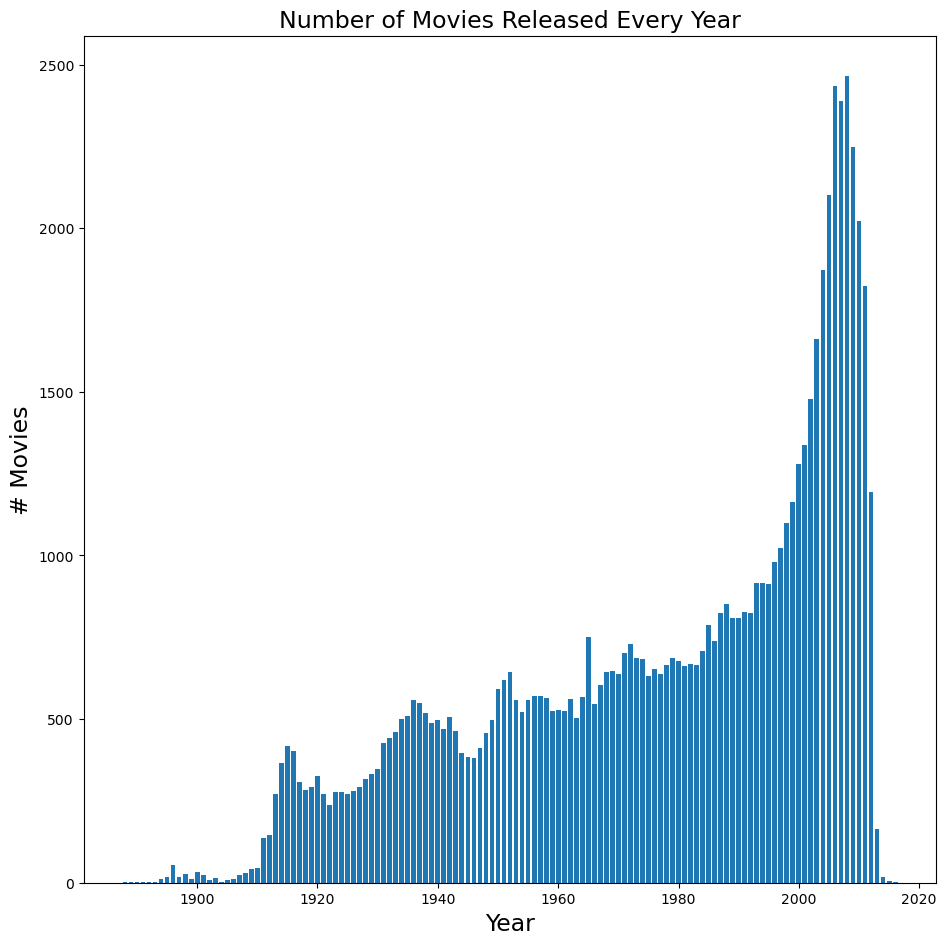

In [55]:
# get the release year of each movie and group movies by it
movie_metadata['year'] = movie_metadata['movie_release_date'].apply(lambda x:x.year)
movie_metadata_year = movie_metadata.groupby(['year'])
sizes = movie_metadata_year.size()

plt.figure(figsize=(11,11))
plt.bar(sizes.index, sizes)
plt.xlabel('Year',fontsize=17)
plt.ylabel('# Movies',fontsize=17)
plt.title('Number of Movies Released Every Year',fontsize=17)
plt.show()

The number of movie is enough for annual analysis (after 1920). 

## Analyze revenue data.

Is the revenue data complete?

In [56]:
total_movie_number = movie_metadata.shape[0]
movie_meta_data_revenue = movie_metadata.dropna(subset=['movie_box_office_revenue'])
print('Movie with Revenue: ', movie_meta_data_revenue.shape[0])
print('Total Movie Number: ', total_movie_number)

Movie with Revenue:  8401
Total Movie Number:  81741


##### Additional revenue data

The number of movies with revenue data is a bit small. We need to enrich the data with other sources of revenue information.

We tried to find a revenue dataset from https://zenodo.org/record/1240586#.Y3eqfOyZOrM

There are other revenue datasets like IMDB mojo and OpusData, but they are not free. We may try to contact them for help in the future.

In [57]:

def get_additional_revenue_data():
    import sys
    from SPARQLWrapper import SPARQLWrapper, JSON

    # query wikidata SPARQL endpoint
    def get_results(query):
        user_agent = "WDQS-example Python/%s.%s" % (
            sys.version_info[0],
            sys.version_info[1],
        )
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()

    # Since movie_metadata uses Freebase IDs, and this additional data uses IMDB IDs, we need to convert them.
    def imdb_id_to_freebase_id(imdb_id):
        """imdb id to freebase id, e.g., tt0228333 -> /m/03vyhn"""

        query = (
            """SELECT DISTINCT ?item ?itemLabel ?freebaseId WHERE {
            SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
            {
            SELECT DISTINCT ?item WHERE {
                ?item p:P345 ?statement0.
                ?statement0 ps:P345 "%s".
            }
            LIMIT 1
            }
            OPTIONAL { ?item wdt:P646 ?freebaseId. }
        }"""
            % imdb_id
        )
        try:
            results = get_results(query)
            return results["results"]["bindings"][0]["freebaseId"]["value"]
        except Exception:
            return None

    # dataset from https://zenodo.org/record/1240586#.Y3eqfOyZOrM
    additional_revenue_data = pd.read_csv("./data/movies.csv", sep=";")
    print(additional_revenue_data.columns)

    additional_revenue_data = additional_revenue_data[
        ["imdb_id", "original_title", "release_date", "revenue"]
    ]
    additional_revenue_data = additional_revenue_data[
        additional_revenue_data["imdb_id"].notna()
    ]
    additional_revenue_data = additional_revenue_data[
        additional_revenue_data["revenue"] > 0
    ]

    for cnt, i in enumerate(additional_revenue_data.index):
        additional_revenue_data.loc[i, "freebase_movie_id"] = imdb_id_to_freebase_id(
            additional_revenue_data.loc[i, "imdb_id"]
        )

    additional_revenue_data = additional_revenue_data[
        additional_revenue_data["freebase_movie_id"].notna()
    ][["freebase_movie_id", "revenue"]]
    additional_revenue_data.reset_index(drop=True, inplace=True)

    pickle.dump(
        additional_revenue_data, open("./data/additional_revenue_data.pkl", "wb")
    )


# load preprocessed data
additional_revenue_data = pickle.load(open("./data/additional_revenue_data.pkl", "rb"))
additional_revenue_data

,freebase_movie_id,revenue
0,/m/02pg45,4300000
1,/m/03dymt,12136938
2,/m/0dtfn,775398007
3,/m/01jrbb,940335536
4,/m/0bdjd,677945399
...,...,...
7506,/m/02rw0zh,2350000
7507,/m/047mwbd,380
7508,/m/0gkt73l,3707
7509,/m/026vcrq,80000


In [58]:
# Join additional revenue data to movie_metadata

merged = movie_metadata.merge(
    additional_revenue_data, on="freebase_movie_id", how="left"
)
merged["movie_box_office_revenue"] = merged["movie_box_office_revenue"].fillna(
    merged["revenue"]
)
merged.drop(columns=["revenue"], inplace=True)
movie_metadata = merged

movie_meta_data_revenue = movie_metadata.dropna(subset=["movie_box_office_revenue"])
print("Movie with Revenue after augmentation: ", movie_meta_data_revenue.shape[0])

Movie with Revenue after augmentation:  10306


What is the trend of average revenue across time?

In [4]:
#define bootstrap_CI function
def bootstrap_CI(data, nbr_draws=1000):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5), np.nanpercentile(means, 97.5)]

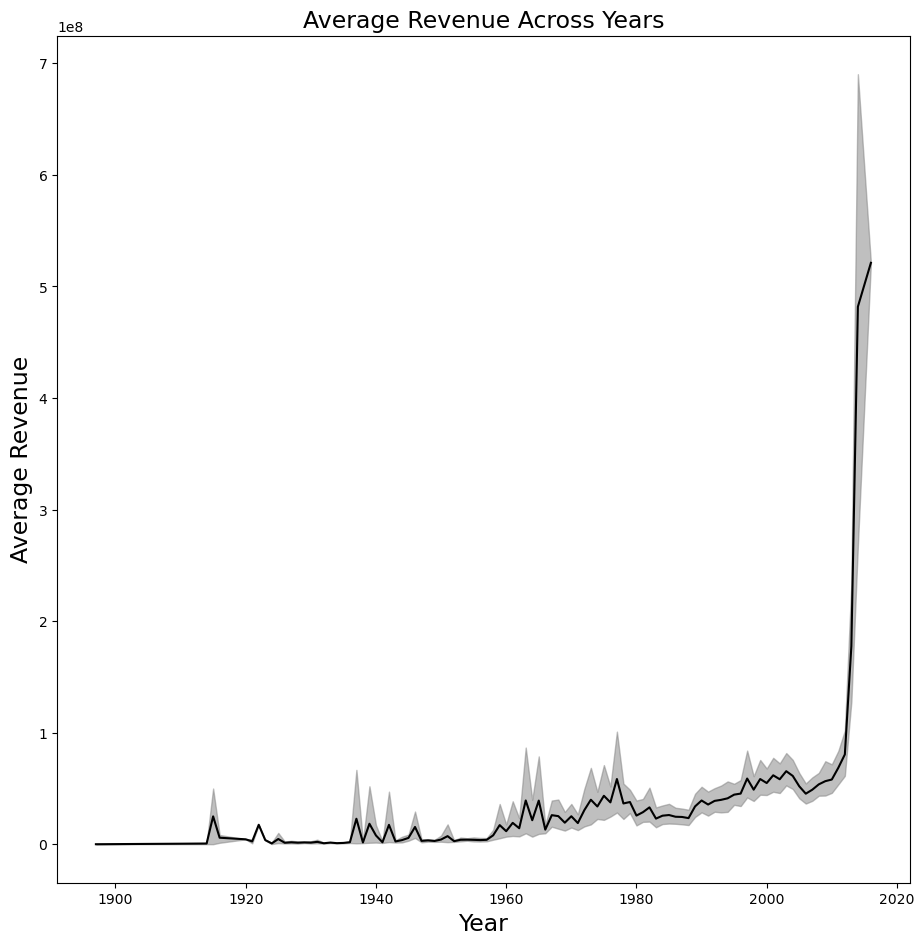

In [59]:
movie_meta_data_revenue_year = movie_meta_data_revenue.groupby("year")
movie_meta_data_revenue_year_mean = movie_meta_data_revenue_year.mean()

year_data = []
for _, group in movie_meta_data_revenue_year:
    year_data.append(bootstrap_CI(group["movie_box_office_revenue"].values, nbr_draws=1000))
year_data = np.stack(year_data).transpose(1, 0)

plt.figure(figsize=(11, 11))
plt.fill_between(
    movie_meta_data_revenue_year_mean.index,
    year_data[0],
    year_data[1],
    alpha=0.5,
    color="gray",
)

plt.plot(movie_meta_data_revenue_year_mean.movie_box_office_revenue, color="black")
plt.xlabel("Year", fontsize=17)
plt.ylabel("Average Revenue", fontsize=17)
plt.title("Average Revenue Across Years", fontsize=17)
plt.show()

Error area is 95CI. The average revenue is gradually going up, which meets our expectation. The trend also shows the feasiblity of doing time-related analysis.

## Genre counts and group


In [60]:
# convert dict-format string to dictionary
from collections import defaultdict
genres = movie_metadata['movie_genres'].apply(eval)
def zero_count():
  return 0

# count the time that a certain genre occurs
genre_count = defaultdict(zero_count)
for i, genre_dict in enumerate(genres):
  for key in genre_dict.keys():
    genre_count[genre_dict[key]] += 1
print('Total Number of Genre: ', len(genre_count.keys()))

Total Number of Genre:  363


Many genres here. How many times does each genre occur?

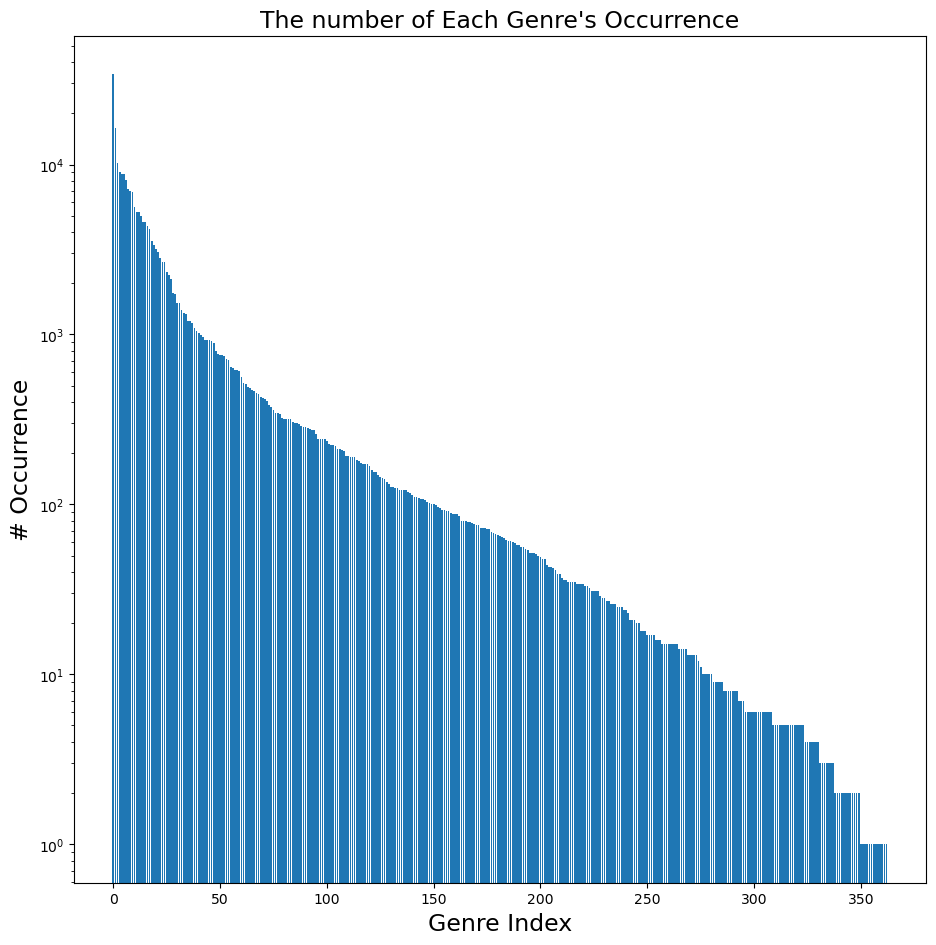

In [61]:
genre_count_sorted = sorted(genre_count.items(), key = lambda x:x[1], reverse = True)
plt.figure(figsize=(11,11))
plt.bar(np.arange(len(genre_count.keys())), [x[1] for x in genre_count_sorted])
plt.yscale('log')
plt.xlabel('Genre Index', fontsize=17)
plt.ylabel('# Occurrence', fontsize=17)
plt.title('The number of Each Genre\'s Occurrence', fontsize=17)
plt.show()

Heavy-tailed distribution. It means that many genres occur not so many times. What are the genres that occur more than 1000 times?

In [62]:
[x for x in genre_count_sorted if x[1] > 1000]

[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Black-and-white', 9094),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630),
 ('Horror', 5280),
 ('Silent film', 5250),
 ('Adventure', 4963),
 ('Family Film', 4598),
 ('Action/Adventure', 4561),
 ('Comedy film', 4362),
 ('Musical', 4160),
 ('Animation', 3534),
 ('Romantic drama', 3372),
 ('Mystery', 3195),
 ('Science Fiction', 3052),
 ('Fantasy', 2820),
 ('Romantic comedy', 2680),
 ('War film', 2652),
 ('Japanese Movies', 2322),
 ('Western', 2226),
 ('Crime Thriller', 2122),
 ('Period piece', 1758),
 ('Comedy-drama', 1720),
 ('Film adaptation', 1531),
 ('Chinese Movies', 1525),
 ('Biography', 1392),
 ('Psychological thriller', 1331),
 ('Bollywood', 1321),
 ('Sports', 1206),
 ('Biographical film', 1198),
 ('LGBT', 1163),
 ('Music', 1088),
 ('Family Drama', 1043),
 ('Black comedy', 1025)]

Qualitatively speaking, there is little overlap between different top-occur genres. We can focus on those top-occur genres when performing genre-related analysis. If needed, we can also perform genre clustering to reduce the number of genres, and ensure that each genre (after clustering) can appear enough times for analysis.

# Initial Analysis on our proposal
For an initial analysis, only consider movies released after 2000 to speed up.

In [63]:
movie_metadata = movie_metadata.query('year > 2000')
print('Number of Movies: ',movie_metadata.shape[0])
# Check the Iron Man item
movie_metadata[movie_metadata['movie_id'] == 5676692]

Number of Movies:  23216


,movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year
46672,5676692,/m/0dzlbx,Iron Man,2008-04-14,585174222.0,126.0,"{""/m/032f6"": ""Persian Language"", ""/m/0jzc"": ""A...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2008.0


In [64]:
# merge plot data and movie metadata
movie_data = pd.merge(left = movie_metadata, right = movie_plot, left_on = 'movie_id', right_on = 'movie_id', how = 'inner')
print('Total Movie Number: ', movie_data.shape[0])
movie_data[movie_data['movie_id'] == 5676692]

Total Movie Number:  14736


,movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year,Plot
8379,5676692,/m/0dzlbx,Iron Man,2008-04-14,585174222.0,126.0,"{""/m/032f6"": ""Persian Language"", ""/m/0jzc"": ""A...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2008.0,"Playboy and genius Tony Stark, who has inherit..."


## 1. What do those blockbusters have in their plots?
We want to see whether the top-selling movies are characterized by certain topics or keywords both qualitatively and quantitatively. 

### 1.1 Topic modeling of plots: LDA
#### 1.1.1 Clean the text. 
1. Excluding stop words and punctuations.
2. Tokenizing the sentence.
3. Delete name of person using NER.

In [ ]:
# 1.1
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import nltk

nltk.download("popular", quiet=True)
from nltk.corpus import stopwords  # load stopwords to exclude
from nltk.tokenize import word_tokenize
import string
from nltk.stem.wordnet import WordNetLemmatizer  # word tokenizer
import spacy
import en_core_web_sm

import pickle
import os

In [5]:

def clean(text):
    # exclude stop words
    ner_result = NER(text)
    name_list = []
    for x in ner_result:
        if x.ent_iob_ != "O":
            name_list.append(x.text.lower())
    word_list = [word.lower() for word in word_tokenize(text)]
    no_name_no_stop = " ".join(
        [word for word in word_list if word not in name_list and word not in stop]
    )
    # exclude punctuations
    punc_free = "".join(ch for ch in no_name_no_stop if ch not in exclude)
    # turn the sentence into a list of words->word tokenize, and lemmatize the word
    tokenized = " ".join(
        [lemma.lemmatize(word) for word in punc_free.split() if len(word) > 2]
    )
    return tokenized.split()

In [ ]:
from nltk.corpus.reader.categorized_sents import word_tokenize

# load stop words for English
stop = set(stopwords.words("english"))
# load punctuations
exclude = set(string.punctuation)
# initialize work tokenizer
lemma = WordNetLemmatizer()
# initialize the NER model
NER = en_core_web_sm.load()


movie_data["plot_clean"] = movie_data["Plot"].apply(clean)
with open("./data/movie_data_plot_clean.pkl", "wb") as f:
    pickle.dump(movie_data["plot_clean"], f, pickle.HIGHEST_PROTOCOL)
plot_clean_example = " ".join(
    movie_data[movie_data["movie_id"] == 5676692]["plot_clean"].iloc[0]
)
movie_data[movie_data["movie_id"] == 5676692]

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


,movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year,Plot,plot_clean
8379,5676692,/m/0dzlbx,Iron Man,2008-04-14,585174222.0,126.0,"{""/m/032f6"": ""Persian Language"", ""/m/0jzc"": ""A...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2008.0,"Playboy and genius Tony Stark, who has inherit...","[genius, inherited, defense, contractor, fathe..."


### 1.2 Extract topics from the cleaned text using LDA. 


In [ ]:
# 1.2.1
# create word dictionary
plot_word_dictionary = corpora.Dictionary(movie_data['plot_clean'])
# remove the word that appears less than 5 times.
plot_word_dictionary.filter_extremes(no_below=5, no_above=1.0, keep_n=None)
# fill in the gap between word indices after removing word 
plot_word_dictionary.compactify()
#Total number of non-zeroes in the BOW matrix (sum of the number of unique words per document over the entire corpus).
print('Total Unique word: ',len(plot_word_dictionary))

doc_term_matrix = [plot_word_dictionary.doc2bow(doc) for doc in movie_data['plot_clean'] ]
print('Total Documents: ',len(doc_term_matrix))

lda = LdaMulticore

# for initial analysis, we hard-code the number of topics to 10 but this can be further improved
num_topics=10
ldamodel = lda(doc_term_matrix,num_topics=num_topics,id2word=plot_word_dictionary,passes=20,minimum_probability=0)

Total Unique word:  16477
Total Documents:  14736


What are those topics?

In [ ]:
topics = ldamodel.show_topics(num_topics=num_topics, formatted=False)
topics

[(0,
  [('police', 0.018639911),
   ('money', 0.013178339),
   ('get', 0.011080569),
   ('kill', 0.009316398),
   ('gang', 0.008873689),
   ('drug', 0.007561411),
   ('take', 0.007447657),
   ('murder', 0.0060390914),
   ('officer', 0.005928064),
   ('also', 0.00580187)]),
 (1,
  [('village', 0.010916871),
   ('life', 0.007264635),
   ('father', 0.0071323165),
   ('kill', 0.006513219),
   ('family', 0.005692732),
   ('son', 0.005651621),
   ('young', 0.005621315),
   ('fight', 0.005422481),
   ('death', 0.0052954806),
   ('power', 0.004968019)]),
 (2,
  [('tell', 0.01568472),
   ('find', 0.012510666),
   ('house', 0.011025509),
   ('see', 0.010110673),
   ('room', 0.008494705),
   ('back', 0.007533406),
   ('go', 0.0072742146),
   ('man', 0.0064427303),
   ('home', 0.006341901),
   ('say', 0.0057245633)]),
 (3,
  [('school', 0.04724995),
   ('student', 0.030373236),
   ('friend', 0.021618696),
   ('teacher', 0.0134989405),
   ('college', 0.0127394),
   ('high', 0.012442631),
   ('class

For properly choosing the number of topics, we can use coherence score of the current topic model.

In [ ]:
num_topic_list = [10,15,20]
for n in num_topic_list:
  lda_model_select = lda(doc_term_matrix,num_topics=n,id2word=plot_word_dictionary,passes=20,minimum_probability=0)
  coherence_model_lda = CoherenceModel(model=lda_model_select, texts=movie_data['plot_clean'], dictionary=plot_word_dictionary, coherence='c_v')
  coherence = coherence_model_lda.get_coherence()
  print("Topic Number: ",n,"Coherence :" , coherence)

Topic Number:  10 Coherence : 0.3703659198743236
Topic Number:  15 Coherence : 0.3923421282007023
Topic Number:  20 Coherence : 0.37245657487606093


Get the topic id for each movie

In [ ]:
lda_corpus = ldamodel[doc_term_matrix]
topic_id_list = []
for i,doc in enumerate(lda_corpus):
  # doc: [(topic_id, prob of this doc belonging to this topic)]
  doc_topic_id = np.argmax([x[1] for x in doc])
  topic_id_list.append(doc_topic_id)
movie_data['topic_id'] = topic_id_list
movie_data[movie_data['movie_id'] == 5676692]

,movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year,Plot,plot_clean,topic_id
8379,5676692,/m/0dzlbx,Iron Man,2008-04-14,585174222.0,126.0,"{""/m/032f6"": ""Persian Language"", ""/m/0jzc"": ""A...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2008.0,"Playboy and genius Tony Stark, who has inherit...","[genius, inherited, defense, contractor, fathe...",8


#### Now we want to see whether the average revenue in different topic groups can be different, thus supporting our further analysis.

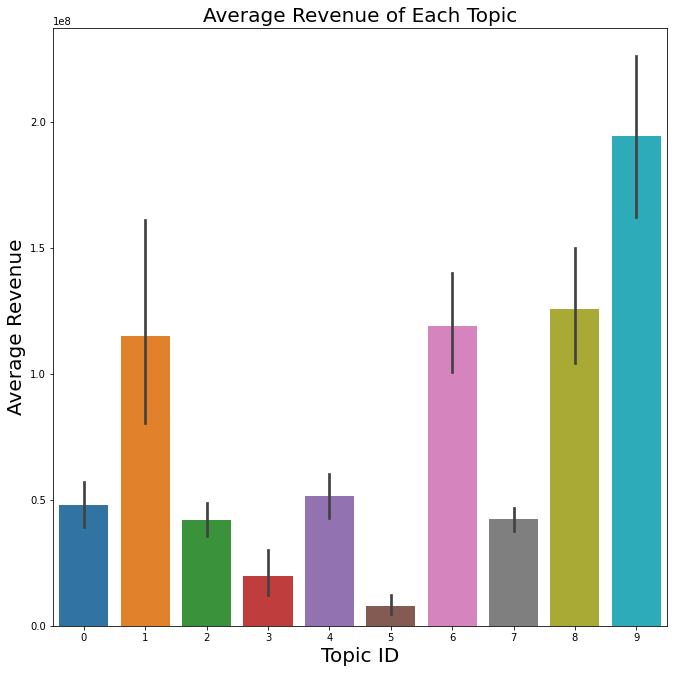

In [ ]:
import seaborn as sns

# Drop the movie without revenue data
movie_data_revenue = movie_data.dropna(subset = ['movie_box_office_revenue'])
movie_data_topic_group = movie_data_revenue[['movie_box_office_revenue','topic_id']].groupby(['topic_id'], as_index = False)
movie_data_topic_group_mean = movie_data_topic_group.mean()

plt.figure(figsize=(11,11))
sns.barplot(x = 'topic_id', y = 'movie_box_office_revenue', data = movie_data_revenue)
plt.xticks(np.arange(num_topics))
plt.xlabel('Topic ID',fontsize=20)
plt.ylabel('Average Revenue',fontsize=20)
plt.title('Average Revenue of Each Topic',fontsize=20)
plt.show()

Error bar is 95 CI. Difference can be observed between different groups. We can further quantitatively estimate the differences.

#### What are the top-selling topics?

In [ ]:
revenue_list = movie_data_topic_group_mean['movie_box_office_revenue']
revenue_sorted = np.array(np.argsort(revenue_list))
topics = ldamodel.show_topics(num_topics=num_topics, formatted=False)
for idx in revenue_sorted[-3:]:
  print(topics[idx])

(6, [('find', 0.009430872), ('escape', 0.0075259367), ('back', 0.006597764), ('group', 0.0062060202), ('car', 0.0053907493), ('take', 0.0049347333), ('kill', 0.0046195504), ('get', 0.004609725), ('attack', 0.004587156), ('begin', 0.004268412)])
(8, [('agent', 0.0074165636), ('soldier', 0.006022716), ('order', 0.0057664956), ('team', 0.005677013), ('president', 0.0046002995), ('bomb', 0.004478669), ('men', 0.0042148354), ('mission', 0.0040919227), ('plan', 0.0040745805), ('attempt', 0.00398584)])
(9, [('find', 0.011256648), ('back', 0.0109463325), ('tell', 0.007299042), ('take', 0.0061308146), ('get', 0.0060540554), ('time', 0.005222417), ('help', 0.00504035), ('friend', 0.0050078747), ('away', 0.004945589), ('however', 0.004926848)])


#### We also want to investigate whether certain keywords in movie plots can contribute to revenues.

### 1.3 Keywords extraction of each plot, by KeyBERT

In [ ]:
def extract_keywords(word_list):
  text = ' '.join(word_list)
  keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 3), stop_words=None, use_mmr=True, diversity=0.5, top_n = 20)
  return keywords

In [ ]:
# Weighted sum of keyword to form keyword vectors
def keyword2vec_weighted(keywords):
  keyword_prob_max = keywords[0][1]
  word_vec = np.zeros((word_vec_dim))
  word_num = 1
  for keyword_prob in keywords:
    word_list = keyword_prob[0].split()
    word_prob = float(keyword_prob[1]) 
    if(word_prob < 0.1):
      continue
    word_prob = word_prob / keyword_prob_max
    for word in word_list:
      try:
        word_vec = word_vec + word_prob * embeddings[word2index[word]]
        word_num += 1
      except:
        # print(word)
        pass
    return word_vec / word_num

In [ ]:
# Un-weighted sum of keyword to form keyword vectors
def keyword2vec_unweight(keywords):
  keyword_prob_max = keywords[0][1]
  word_vec = np.zeros((word_vec_dim))
  word_num = 1
  for keyword_prob in keywords:
    word_list = keyword_prob[0].split()
    word_prob = float(keyword_prob[1]) 
    if(word_prob < 0.1):
      continue
    for word in word_list:
      try:
        word_vec = word_vec + embeddings[word2index[word]]
        word_num += 1
      except:
        # print(word)
        pass
    return word_vec / word_num

In [ ]:
# 1.3
!pip install -q keybert
from keybert import KeyBERT
# Load the best KeyBERT model for English text
kw_model = KeyBERT('all-MiniLM-L6-v2')

movie_data_sampled = movie_data.sample(1000)
movie_data_sampled['plot_keyword_list'] = movie_data_sampled['plot_clean'].apply(extract_keywords)
movie_data_sampled['plot_keyword_vec_weighted'] = movie_data_sampled['plot_keyword_list'].apply(keyword2vec_weighted)
movie_data_sampled['plot_keyword_vec_unweighted'] = movie_data_sampled['plot_keyword_list'].apply(keyword2vec_unweight)

     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 237 kB 38.1 MB/s 
     |████████████████████████████████| 51 kB 4.6 MB/s 
     |████████████████████████████████| 5.5 MB 43.3 MB/s 
     |████████████████████████████████| 1.3 MB 43.5 MB/s 
     |████████████████████████████████| 182 kB 60.6 MB/s 
     |████████████████████████████████| 7.6 MB 37.6 MB/s 


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Since keywords are different for each movie and there is no natural clustering effect between keywords (unlike topic modeling), we propose to use unsupervised clustering to see whether the keywords can appear certain clusters and further group movies according to keywords.

#### 1.3.1 Keyword vectors clustering and visualization

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

keyword_vectors = np.stack(movie_data_sampled['plot_keyword_vec_weighted'].values)
# KMeans model with the target of building 20 clusters
kmeans = KMeans(n_clusters=20, random_state=0)
kmeans_res = kmeans.fit(keyword_vectors)
# Count how many movies are there in each cluster 
label_cnt = np.bincount(kmeans_res.labels_)
# Pick top-10 biggest clusters for visualization
top_10_cluster = np.argsort(label_cnt)[-10:]

Visualize top-10 biggest clusters

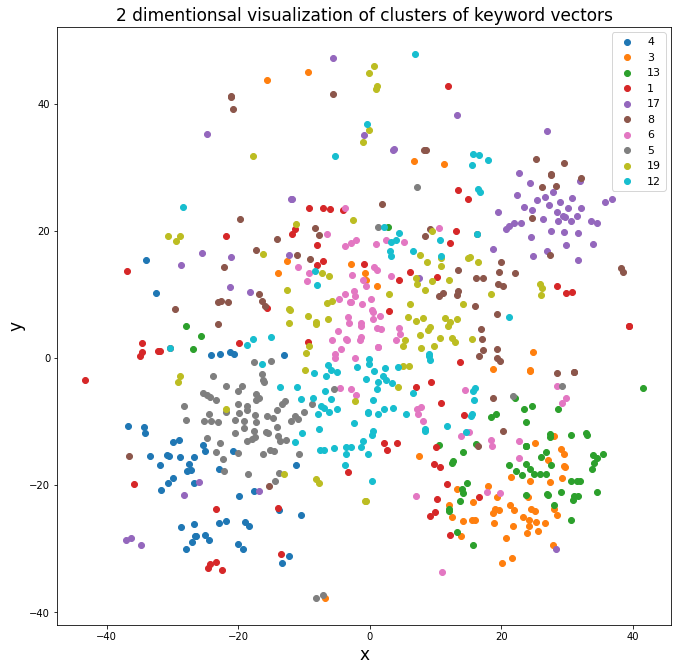

In [ ]:
# Use t-SNE for dimensionality reduction
tsne = TSNE(perplexity=20, random_state=42)
keyword_vectors_2dim = tsne.fit_transform(keyword_vectors)

plt.figure(figsize=(11,11))
for label_idx in top_10_cluster:
  plt.scatter(keyword_vectors_2dim[np.where(kmeans_res.labels_==label_idx),0],keyword_vectors_2dim[np.where(kmeans_res.labels_==label_idx),1], label = f"{label_idx}")
plt.legend(fontsize=11)
plt.xlabel('x', fontsize=17)
plt.ylabel('y', fontsize=17)
plt.title('2 dimentionsal visualization of clusters of keyword vectors', fontsize=17)
plt.show()

#### 1.3.2 Are the clusters of keywords containing only few topics?

We want to see whether the topics in one cluster of keywords are different, to ensure that we are not repeating the analysis of topic-grouped movies.

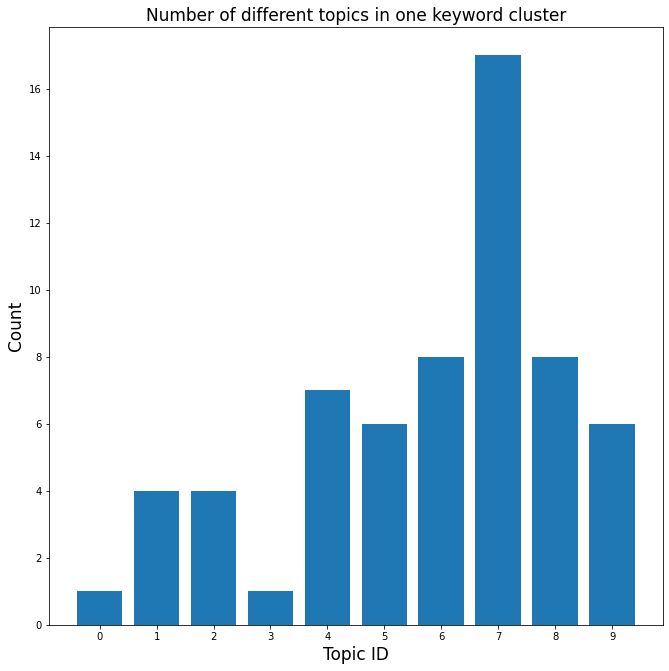

In [ ]:
movie_data_sampled['keyword_cluster_id'] = kmeans_res.labels_
movie_data_sampled_group_keyword = movie_data_sampled.groupby('keyword_cluster_id')
for i, group in movie_data_sampled_group_keyword:
  topics = group['topic_id']
  topic_count = np.bincount(topics)
  if(i == 1):
    break
plt.figure(figsize=(11,11))
plt.bar(np.arange(len(topic_count)),topic_count)
plt.xticks(np.arange(num_topics),np.arange(num_topics))
plt.xlabel('Topic ID', fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.title('Number of different topics in one keyword cluster', fontsize=17)
plt.show()

Different topics can be contained in the same cluster. Therefore, it is meaningful to perform analysis on both topics and keywords

#### 1.3.3 Are the average revenue of each keyword cluster different? 

/usr/local/lib/python3.7/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


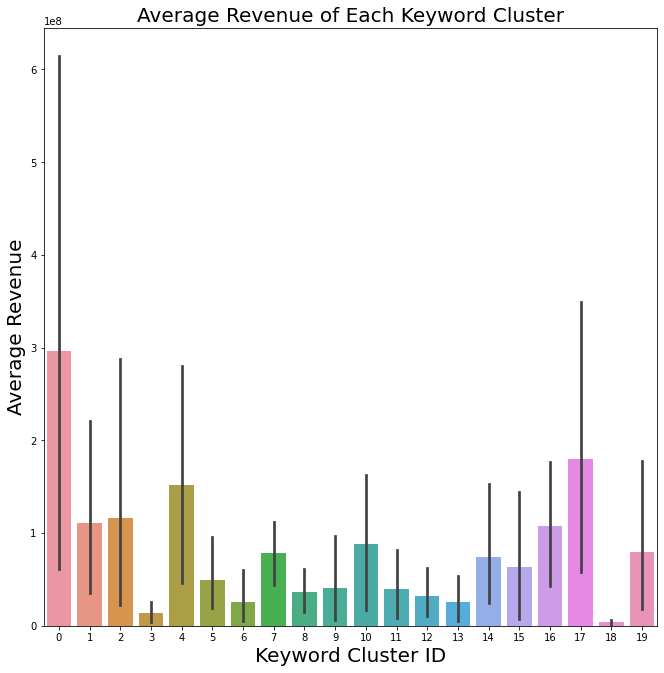

In [ ]:
movie_data_sampled_group_keyword_mean = movie_data_sampled_group_keyword.mean()
plt.figure(figsize=(11,11))
sns.barplot(x = 'keyword_cluster_id', y = 'movie_box_office_revenue', data = movie_data_sampled, errorbar = 'ci')
plt.xticks(np.arange(20))
plt.xlabel('Keyword Cluster ID',fontsize=20)
plt.ylabel('Average Revenue',fontsize=20)
plt.title('Average Revenue of Each Keyword Cluster',fontsize=20)
plt.show()

The average revenue looks different between different keyword clusters, supporting our further keyword-based analysis on revenue.

In [ ]:
# 1.5.2 & 1.5.3

### 1.4 Split movies into different genres (groupby)
#### 1.4.1 Decide main genres by frequency
#### 1.4.2 For movies belonging to each main genre, perform topic and keywords analysis. Can we find a set of words that can bring more revenues to a certain genre of movies but undermines the revenues of another genre of movies?

In [ ]:
# 1.6

### 1.5 Time-related topic & keywords changing
#### 1.5.1 Discretize time. (Decades, five-year, etc.)
#### 1.5.2 In each time period, perform topics and keywords anaylsis. This can be also combined with genre-related analysis to see whether the money-making keywords and topics have changed with time.

In [ ]:
# 1.5

#### 1.6 Before casting an actor, does the actor fit the movie?
Is there a certain set of actors that can bring much more revenue to movies belonging to certain topics or keywords clusters, but have terrible performance under other kinds of movies?

In [ ]:
# 1.6


#### Problems:
1. Do we need to combine genres and time? May result in too many groups of data and lack of amount of data in each group.

## 2. How will top blockbusters affect the revenues of other movies released in a close period?

### 2.1 What is a top blockbuster
There is no quantitative definition about blockbuster given by the film industry. Therefore, we give a simple and clear definition of top blockbusters. We simply define them as the annual box office champions. However, based on their revenue, we can also refine the blockbusters to different levels(eg. With box office revenue higher than 1 billion,2 billion...)

In [ ]:
#To give an example, we could simply use the movie 'Avatar' released in 2009 with a box office revenue of nearly 2.8 billion

example = copy.deepcopy(movie_metadata)
time_split = pd.to_datetime(example['movie_release_date'])
example['month'] = time_split.apply(lambda x: x.month)
example['year'] = example['year'].astype(np.int64)
# print(example.index)
# for idx in example.index:
#   temp = eval(example.loc[idx,('movie_genres')])
#   print(type(temp))
#   example.loc[idx]['movie_genres'] = temp

# for index,row in example.iterrows():
#   # print(type(row['movie_genres']))
#   row['movie_genres'] = eval(row['movie_genres'])
#   print(type(row['movie_genres']))

ava_example = example.loc[example['movie_name']==('Avatar'),:]
ava_example = ava_example[ava_example['movie_box_office_revenue'].isnull() == False]

# ava_example = example.loc[[2133,23702],:]
# print(ava_example)
ava_example #index is 23702 
# type(ava_example['movie_genres'])
# type(example['movie_genres'].loc[2133])

,movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year,month
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2009,12


### 2.2 How do we define movies released in a close period with the top blockbusters
Given some empirical knowledge about the historical box office, we give a preliminary definition for movies released in a close period with the top blockbusters: Movies that are released in the same month with the top blockbusters are considered to be released in a close period.

In [ ]:
ava_year = ava_example['year'].item()
ava_month = ava_example['month'].item()
# type(ava_year)
close_release =  copy.deepcopy(example.loc[(example['year'] == ava_year) & (example['month']==ava_month) & (example['movie_id'] != ava_example['movie_id'].item())])
close_release = close_release[close_release['movie_box_office_revenue'].isnull() == False]
close_release.shape
# type(close_release['movie_genres'].loc[2133])
# type(example['movie_genres'].loc[2133])

(16, 11)

### 2.3 Assumptions and analysis


* We assume that top blockbusters have a negative influence on the revenues of movies released close to it. 
* In our future experiments, we will analyse the impact on all the movies released close to the top blockbusters for sure, however, now we just wanna illustrate there is such a pattern that supports our assumption. Therefore, we want to visualize the pattern for just one of the movies released close to our selected top blockbuster 'Avatar'.
* To prove our assumption, we wanna minimize the impact on revenues due to those movies' own quality. Although film producers may not agree that box office revenue is an ideal indication of movie quality, we as data scientists, will still make a naive assumption that high box office revenue always means high quality. Therefore, our analysis will be mainly conducted on the median of revenue of those movies released close to the top blockbuster since extremely low revenue may be mainly caused by the movie's own quality, making the blockbuster's effect neglectable while high quality movies could easily overpower this negative influence.(Another movie released in the same month with the annual blockbuster might have just a slightly lower revenue. eg. *Avengers: Age of Ultron* and *Furious 7*)

In [ ]:
##Get the medium in revenue in the close released movies and its generes


medium_rev = close_release.loc[close_release.movie_box_office_revenue<close_release.movie_box_office_revenue.median()]
medium_rev = medium_rev.loc[medium_rev.movie_box_office_revenue == medium_rev.movie_box_office_revenue.max()]
# print(medium_rev)

medium_rev_genre = eval(medium_rev['movie_genres'].item())
print('the median revenue of the close released movies is: {}'.format(medium_rev['movie_box_office_revenue'].item()))
# ava_genre = eval(ava_example['movie_genres'].item())

# print(len(medium_rev_genre),type(runnerup_genre))
# print(len(ava_genre),type(ava_genre))
# for i in runnerup_genre:
#   print(i in ava_genre)

##Get all the movies with a valid box office revenue(not NaN) in that year
mv_same_year = copy.deepcopy(example.loc[(example['year'] == ava_year)])
mv_same_year = mv_same_year[mv_same_year['movie_box_office_revenue'].isnull() == False]
# mv_same_year

genre_rev_diff_list = []
genre_list = []
for genre in medium_rev_genre:
  genre_indices = []
  for index,row in mv_same_year.iterrows():
    # print(type(row['movie_genres']))
    row_genre = eval(row['movie_genres'])
    if genre in row_genre:
      genre_indices.append(index)
  genre_df = copy.deepcopy(mv_same_year.loc[genre_indices,:])
  genre_revenue_mean = genre_df['movie_box_office_revenue'].mean()
  # print(genre_revenue_mean)
  genre_revenue_diff = genre_revenue_mean - medium_rev['movie_box_office_revenue'].item()
  genre_rev_diff_list.append(-genre_revenue_diff)
  genre_list.append(medium_rev_genre[genre])
print(genre_rev_diff_list,genre_list)



the median revenue of the close released movies is: 45302911.0
[-18657817.777777776, 24931643.42105263, -2051518.3096446693, -27997721.569105685, -2796961.3870967776, -31223848.174999997] ['Romantic comedy', 'World cinema', 'Drama', 'Comedy', 'Romantic drama', 'Romance Film']


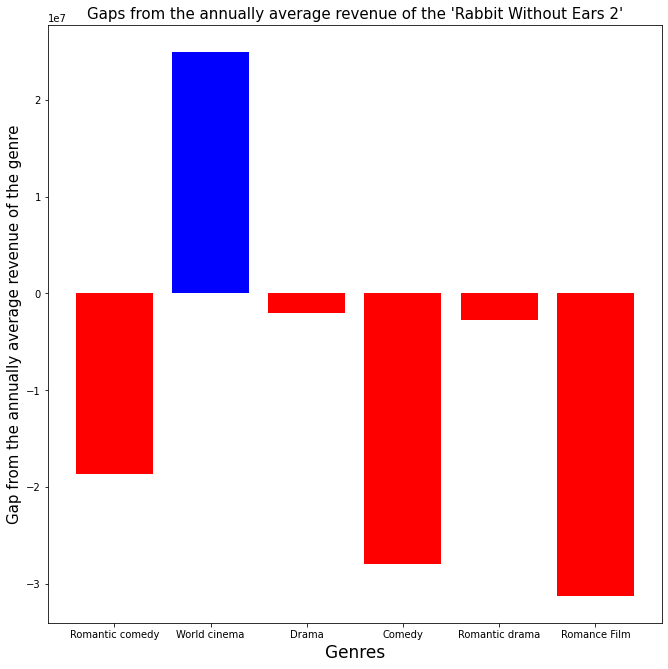

In [ ]:
genre_rev_diff_list = np.asarray(genre_rev_diff_list)
median_name = medium_rev['movie_name'].item()
plt.figure(figsize=(11,11))
plt.bar(genre_list,genre_rev_diff_list,color = np.where(genre_rev_diff_list>0,'b','r'))
plt.xlabel('Genres', fontsize=17)
plt.ylabel('Gap from the annually average revenue of the genre', fontsize=15)
plt.title('Gaps from the annually average revenue of the \''+median_name+ '\'', fontsize=15)
plt.show()

Analysis:

As illustrated in the figure above, one film could have several genres. The selected film has negative gaps(illustrated with red bars) from the annual averages in 5 out of 6 genres, which means it has a lower revenue compared to the average in most of its classified genres. Of course, this single case is far from enough to validate out assumption, but it demonstrates that there is a pattern supporting our assumption and our analysis method is reasonable.

### 2.4 Rule out the influence of released months


*   Hordes of film analysts, more often than not, tend to believe that movies released in different time of the year, even with close topic or genres, have considerably different possibility to reach a high revenue. One classic argument is that movies released between Halloween and Christmas have a much higher chance to get higher revenue than movie released during spring(March,April). One can easily finds tons of examples.(eg. *Frozen* vs *Monsters University*, *Spider-Man: No Way Home* vs *Black Widow*) 
*   To defende out assumption against this potential influence, we also compare the revenue of our selected movie with the average revenue of movies from its genres that are released in the same month of the previous year and the next year. For example, since our selected movie *Rabbit without ears 2* is released in Dec,2009. We will compare its revenue to movies with the same genre that are released in Dec,2008 and Dec,2010




In [ ]:
#Movies from the same month of previous year
mv_pre_year = copy.deepcopy(example.loc[(example['year'] == ava_year-1) & (example['month'] == ava_month)])
mv_pre_year = mv_pre_year[mv_pre_year['movie_box_office_revenue'].isnull() == False]

#Movies from the same month of next year
mv_next_year = copy.deepcopy(example.loc[(example['year'] == ava_year+1) & (example['month'] == ava_month)])
mv_next_year = mv_next_year[mv_next_year['movie_box_office_revenue'].isnull() == False]

genre_pre_rev_diff_list = []
genre_next_rev_diff_list = []
genre_list = []
for genre in medium_rev_genre:
  genre_pre_indices = []
  genre_next_indices = []
  for index,row in mv_pre_year.iterrows():
    # print(type(row['movie_genres']))
    row_genre = eval(row['movie_genres'])
    if genre in row_genre:
      genre_pre_indices.append(index)
  for index,row in mv_next_year.iterrows():
    # print(type(row['movie_genres']))
    row_genre = eval(row['movie_genres'])
    if genre in row_genre:
      genre_next_indices.append(index)


  genre_df_pre = copy.deepcopy(mv_pre_year.loc[genre_pre_indices,:])
  genre_rev_mean_pre = genre_df_pre['movie_box_office_revenue'].mean()
  genre_df_next = copy.deepcopy(mv_next_year.loc[genre_next_indices,:])
  genre_rev_mean_next = genre_df_next['movie_box_office_revenue'].mean()
  # print(genre_revenue_mean)
  genre_rev_diff_pre =  medium_rev['movie_box_office_revenue'].item() - genre_rev_mean_pre
  genre_pre_rev_diff_list.append(genre_rev_diff_pre)
  genre_rev_diff_next =  medium_rev['movie_box_office_revenue'].item() - genre_rev_mean_next
  genre_next_rev_diff_list.append(genre_rev_diff_next)
  genre_list.append(medium_rev_genre[genre])
print(genre_pre_rev_diff_list,genre_next_rev_diff_list)

[-2419984.0, 31231229.25, -62091916.0, -57797013.0, -126254157.0, -78919571.375] [-3365996.0, 34215342.0, -2437284.9090909064, -58063984.25, nan, -13287249.0]


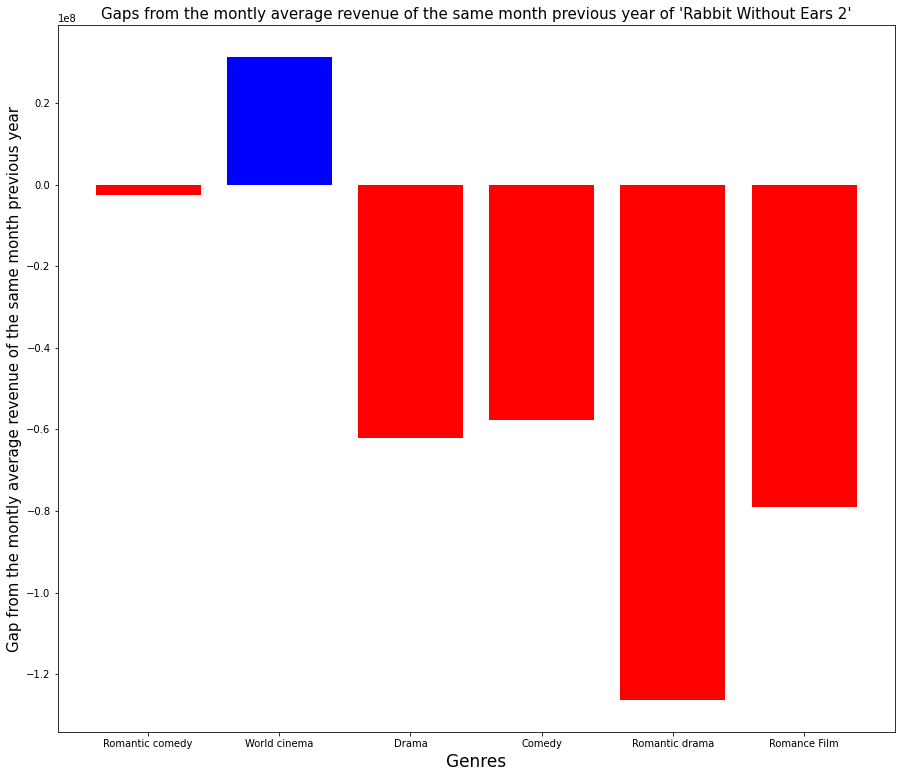

In [ ]:
genre_pre_rev_diff_list = np.asarray(genre_pre_rev_diff_list)
genre_next_rev_diff_list = np.asarray(genre_next_rev_diff_list)
median_name = medium_rev['movie_name'].item()
plt.figure(figsize=(15,13))
plt.bar(genre_list,genre_pre_rev_diff_list,color = np.where(genre_pre_rev_diff_list>0,'b','r'))
plt.xlabel('Genres', fontsize=17)
plt.ylabel('Gap from the montly average revenue of the same month previous year', fontsize=15)
plt.title('Gaps from the montly average revenue of the same month previous year of \''+median_name+ '\'', fontsize=15)
plt.show()

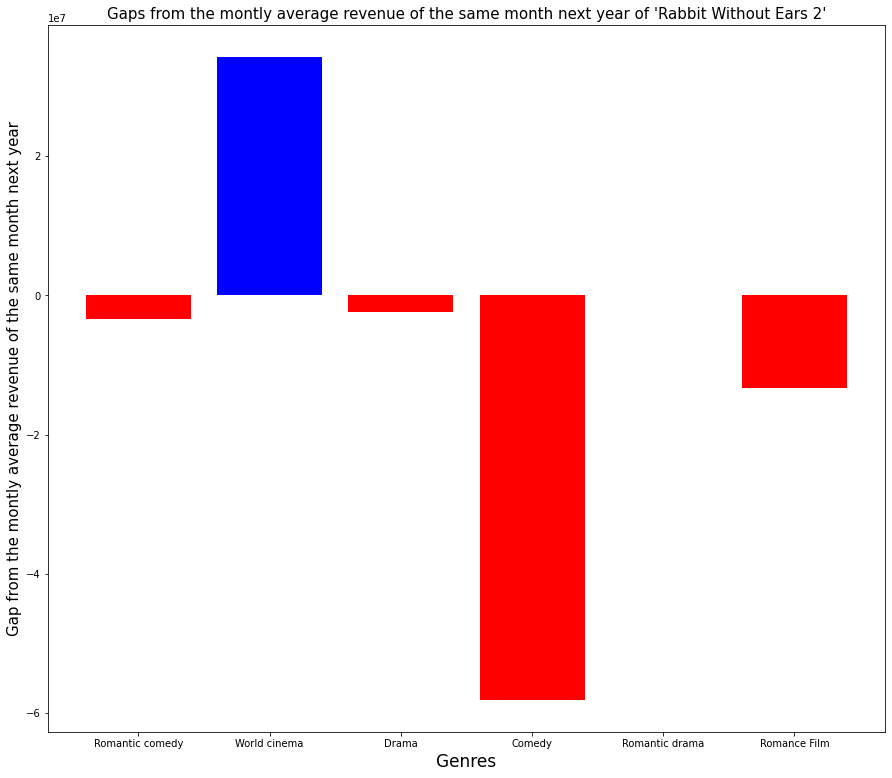

In [ ]:
plt.figure(figsize=(15,13))
plt.bar(genre_list,genre_next_rev_diff_list,color = np.where(genre_next_rev_diff_list>0,'b','r'))
plt.xlabel('Genres', fontsize=17)
plt.ylabel('Gap from the montly average revenue of the same month next year', fontsize=15)
plt.title('Gaps from the montly average revenue of the same month next year of \''+median_name+ '\'', fontsize=15)
plt.show()

Analysis:

As we can see from the two figures above, the revenue of our selected movie *Rabbit without ears 2* is lower than the average revenue from same month previous year and next year in most of its genres. We can also notice that the seleted movie always shows a positive gap in the same genre, namely **World cinema**. This might indicate that *Rabbit without ears 2* is a high quality movie in this specific genre, enabling it to overpower of negative influence of the top blockbuster.

### 2.5 Beyond genres
The analysis based on genres provides us with an intuitive demonstration of blockbusters' influence. However, even movies within the same genre could be extremely different(*Divergent* vs *The Hunger Games*). Therefore, we need a more precise way measure the similarity between movies in order to compare the revenue of our selected movies with its most similar movie that is not affected by any blockbuster. Currently, we have two ideas:


1.   Computing Euclidean distance or cosine similarity between the word vector extracted in Part 1.
2.   Merging the word vector and the other metadata of movies in a latent space and measured distance in that latent space.

However, the final choice and more detailed implementation will need more discussion.
